In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import os
from sklearn.metrics import silhouette_score
import umap
from matplotlib.colors import ListedColormap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_shape_z = pd.read_csv(os.path.join(folder_path, "features_shape_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_shape_mm = pd.read_csv(os.path.join(folder_path, "features_shape_minmax.csv"))


In [3]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_z_cl= df_shape_z.drop(columns=['filename', 'label'])

In [4]:
def _get_init_centers(n_clusters, n_samples):
    '''Return random unique indices as initial medoid centers'''
    return np.random.choice(n_samples, size=n_clusters, replace=False).tolist()

def _get_distance(data1, data2):
    '''Euclidean distance function'''
    return np.sqrt(np.sum((data1 - data2) ** 2))

def _get_cost(X, centers_id, dist_func):
    '''Return members, per-cluster costs, total cost, and distance matrix'''
    dist_mat = np.zeros((len(X), len(centers_id)))
    for j, center_id in enumerate(centers_id):
        center = X[center_id, :]
        for i in range(len(X)):
            if i == center_id:
                dist_mat[i, j] = 0.
            else:
                dist_mat[i, j] = dist_func(X[i, :], center)

    mask = np.argmin(dist_mat, axis=1)
    members = mask.copy()
    costs = np.array([np.sum(dist_mat[mask == i, i]) for i in range(len(centers_id))])
    return members, costs, np.sum(costs), dist_mat

def _kmedoids_run(X, n_clusters, dist_func, max_iter=1000, tol=0.001, verbose=True):
    n_samples = X.shape[0]
    centers = _get_init_centers(n_clusters, n_samples)
    if verbose:
        print("Initial centers are", centers)

    members, costs, tot_cost, dist_mat = _get_cost(X, centers, dist_func)
    cc, swapped = 0, True

    while swapped and cc < max_iter:
        swapped = False
        for i in range(n_samples):
            if i not in centers:
                for j in range(len(centers)):
                    new_centers = deepcopy(centers)
                    new_centers[j] = i
                    members_, costs_, tot_cost_, dist_mat_ = _get_cost(X, new_centers, dist_func)
                    if tot_cost - tot_cost_ > tol:
                        members, costs, tot_cost, dist_mat = members_, costs_, tot_cost_, dist_mat_
                        centers = new_centers
                        swapped = True
                        if verbose:
                            print("Change centers to", centers)
        cc += 1

    if verbose:
        if not swapped:
            print("End Searching by no swaps")
        else:
            print("End Searching by reaching maximum iteration", max_iter)

    return centers, members, costs, tot_cost, dist_mat, cc

class KMedoids:
    '''
    K-Medoids Clustering (PAM) Algorithm

    Parameters
    ----------
    n_clusters : int
        Number of clusters
    dist_func : callable
        Distance function (default: Euclidean)
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance to stop swapping
    '''
    def __init__(self, n_clusters, dist_func=_get_distance, max_iter=1000, tol=0.001):
        self.n_clusters = n_clusters
        self.dist_func = dist_func
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, plotit=True, verbose=True):
        self.X_train = X
        result = _kmedoids_run(
            X, self.n_clusters, self.dist_func, self.max_iter, self.tol, verbose
        )
        self.centers_, self.labels_, self.costs_, self.total_cost_, self.dist_mat_, self.n_iter_ = result

        if plotit and X.shape[1] == 2:
            self._plot_clusters(X)
        elif plotit:
            print("Plotting only supported for 2D data.")

    def predict(self, X):
        if not hasattr(self, "centers_"):
            raise RuntimeError("Model has not been fitted.")
        labels = np.zeros(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = [self.dist_func(x, self.X_train[c]) for c in self.centers_]
            labels[i] = np.argmin(dists)
        return labels

    def _plot_clusters(self, X):
        plt.figure(figsize=(8, 6))
        cmap = plt.get_cmap('tab10')
        for i in range(self.n_clusters):
            cluster_points = X[self.labels_ == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=cmap(i), alpha=0.5, label=f'Cluster {i}')
            plt.scatter(X[self.centers_[i], 0], X[self.centers_[i], 1],
                        color=cmap(i), marker='*', s=300, edgecolor='k')
        plt.title("K-Medoids Clustering")
        plt.legend()
        plt.grid(True)
        plt.show()

t-SNE no tiene un método .transform(), por lo que NO puedes transformar los medoides
como lo haces con UMAP. Esto es una limitación de t-SNE.

Initial centers are [21, 446]
Change centers to [3, 446]
Change centers to [5, 446]
Change centers to [10, 446]
Change centers to [10, 15]
Change centers to [18, 15]
Change centers to [18, 54]
Change centers to [74, 54]
Change centers to [74, 100]
Change centers to [74, 469]
Change centers to [74, 534]
Change centers to [150, 534]
End Searching by no swaps
Etiquetas únicas: [0 1]


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


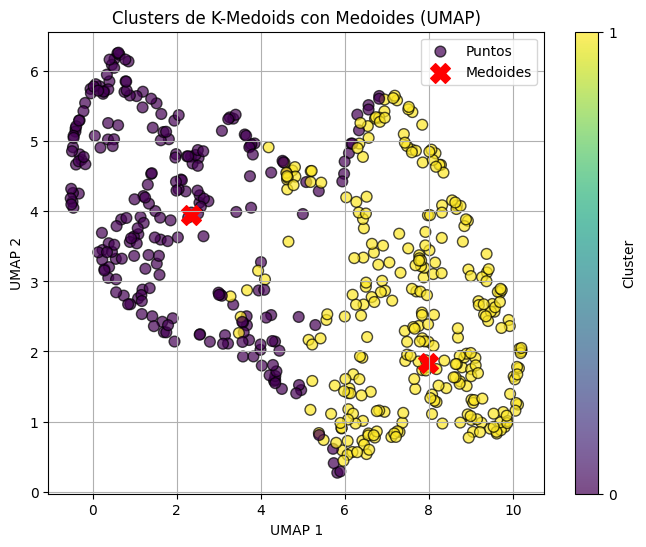

In [5]:
X_z = df_shape_z_cl.to_numpy()

# Crear modelo K-Medoids 
model = KMedoids(n_clusters=2)
model.fit(X_z, plotit=False)

# Verifica que solo haya 2 etiquetas
print("Etiquetas únicas:", np.unique(model.labels_))

# Reducir dimensionalidad a 2D con UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2D = umap_model.fit_transform(X_z)

# Transformar coordenadas de los medoides al espacio 2D
medoids_2D = umap_model.transform(X_z[model.centers_])



# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2D[:, 0], X_2D[:, 1],
    c=model.labels_,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D[:, 0], medoids_2D[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles de la gráfica
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
score = silhouette_score(X_z, model.labels_)
print(f"Coeficiente de silueta: {score:.4f}")

Coeficiente de silueta: 0.3297


In [ ]:
y_true = df_shape_z['label'].values
y_pred = model.labels_
tabla_contingencia = pd.crosstab(y_true, y_pred, rownames=['Etiqueta real'], colnames=['Cluster K-Medoids'])
print(tabla_contingencia)


Cluster K-Medoids    0    1
Etiqueta real              
higher_than         29  239
smaller_than       215   54


In [8]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_mm_cl= df_shape_mm.drop(columns=['filename', 'label'])

Initial centers are [404, 493]
Change centers to [0, 493]
Change centers to [2, 493]
Change centers to [3, 493]
Change centers to [5, 493]
Change centers to [10, 493]
Change centers to [10, 54]
Change centers to [74, 54]
Change centers to [74, 100]
Change centers to [74, 469]
Change centers to [74, 534]
Change centers to [150, 534]
End Searching by no swaps
Etiquetas únicas: [0 1]


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


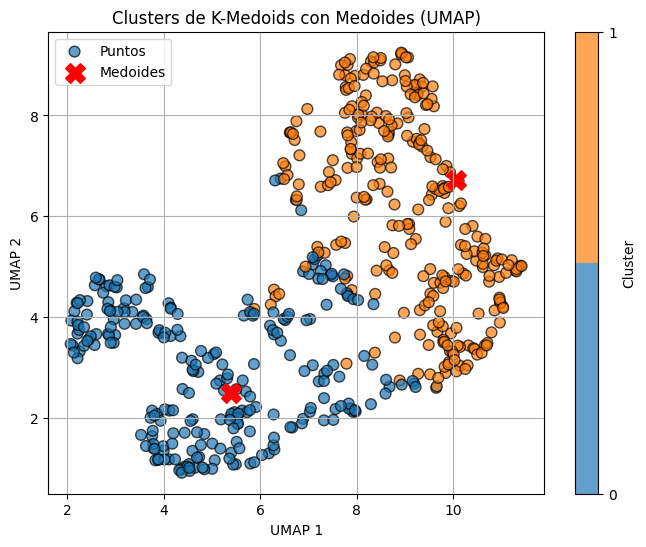

In [9]:
X_mm = df_shape_mm_cl.to_numpy()

# Crear modelo K-Medoids con 2 clusters
model = KMedoids(n_clusters=2)
model.fit(X_mm, plotit=False)

# Verifica que solo haya 2 etiquetas
print("Etiquetas únicas:", np.unique(model.labels_))

# Reducir dimensionalidad a 2D con UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2D = umap_model.fit_transform(X_mm)

# Transformar coordenadas de los medoides al espacio 2D
medoids_2D = umap_model.transform(X_mm[model.centers_])

# Definir colores fijos para 2 clusters
colors = ListedColormap(['#1f77b4', '#ff7f0e'])  # azul y naranja

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2D[:, 0], X_2D[:, 1],
    c=model.labels_,
    cmap=colors,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D[:, 0], medoids_2D[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles de la gráfica
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
score = silhouette_score(X_mm, model.labels_)
print(f"Coeficiente de silueta: {score:.4f}")

Coeficiente de silueta: 0.3192


In [15]:
y_true = df_shape_mm['label'].values
y_pred = model.labels_
tabla_contingencia = pd.crosstab(y_true, y_pred, rownames=['Etiqueta real'], colnames=['Cluster K-Medoids'])
print(tabla_contingencia)

Cluster K-Medoids    0    1
Etiqueta real              
higher_than         31  237
smaller_than       224   45


reduccion de la dimensionalidad con umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Initial centers are [443, 530]
Change centers to [0, 530]
Change centers to [2, 530]
Change centers to [8, 530]
Change centers to [8, 100]
Change centers to [139, 100]
Change centers to [139, 285]
Change centers to [139, 292]
Change centers to [139, 402]
End Searching by no swaps


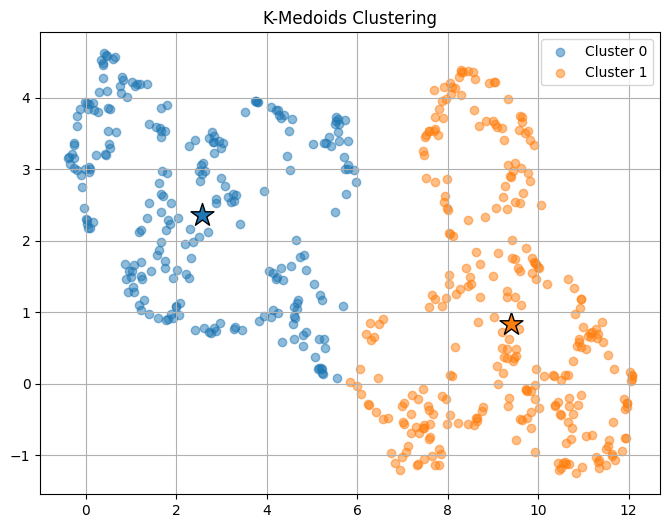

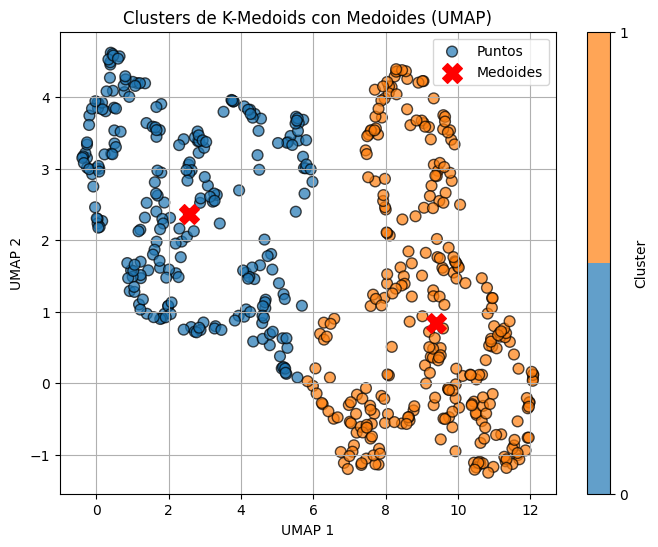

In [11]:

# Reducción con UMAP
umap_model_zscore = umap.UMAP(n_neighbors=10, n_components=2, random_state=42)
X_zscore_umap = umap_model_zscore.fit_transform(X_z)

# K-Medoids sobre datos ya reducidos
model_kmedoids_zscore_umap = KMedoids(n_clusters=2)  
model_kmedoids_zscore_umap.fit(X_zscore_umap)

# Obtener las etiquetas de los clusters
cluster_labels_zscore = model_kmedoids_zscore_umap.labels_

# Obtener las coordenadas 2D de los medoides
medoids_2D_zscore = X_zscore_umap[model_kmedoids_zscore_umap.centers_]

# Colores para 2 clusters
colors = ListedColormap(['#1f77b4', '#ff7f0e'])  # Azul para pequeño, naranja para grande

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_zscore_umap[:, 0], X_zscore_umap[:, 1],
    c=cluster_labels_zscore,  
    cmap=colors,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D_zscore[:, 0], medoids_2D_zscore[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles del gráfico
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [12]:
silhouette_avg = silhouette_score(X_zscore_umap, cluster_labels_zscore)
print(f"Coeficiente de Silueta promedio: {silhouette_avg:.3f}")


Coeficiente de Silueta promedio: 0.574


In [ ]:
etiquetas_reales_z = df_shape_z['label'].values
predicciones_cluster_z = cluster_labels_zscore

tabla_z = pd.crosstab(etiquetas_reales_z, predicciones_cluster_z, 
                    rownames=['Etiqueta real'], colnames=['Cluster asignado'])
print(tabla_z)

Cluster asignado    0    1
Etiqueta real             
higher_than        25  243
smaller_than      220   49


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Initial centers are [14, 443]
Change centers to [14, 59]
Change centers to [161, 59]
Change centers to [161, 225]
Change centers to [161, 281]
Change centers to [161, 308]
Change centers to [161, 360]
End Searching by no swaps


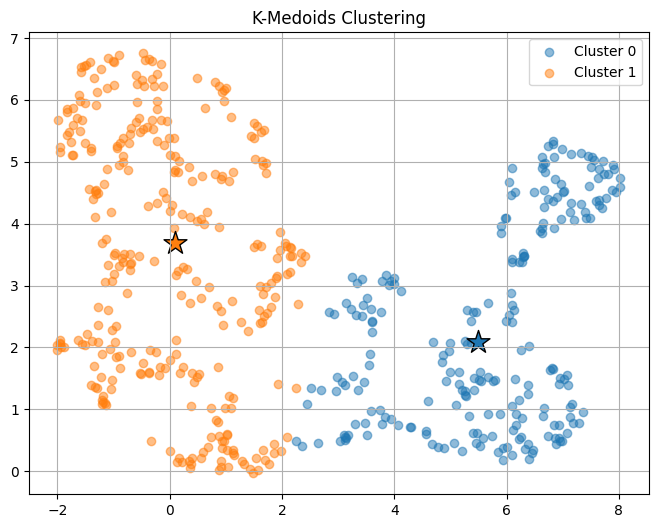

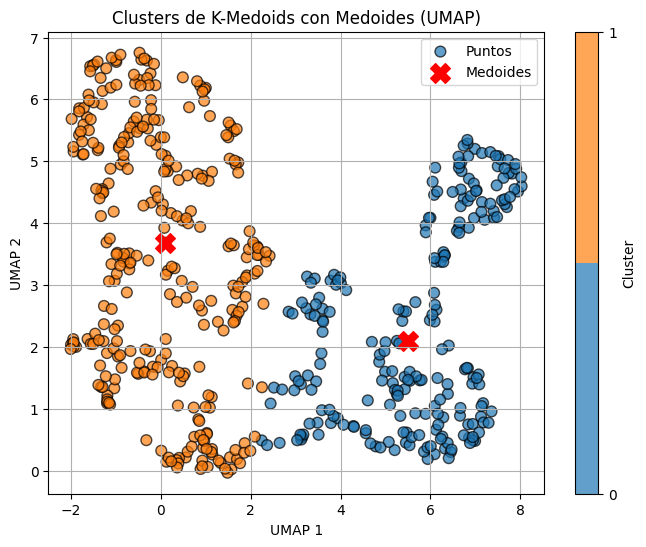

In [13]:
# Reducción con UMAP
umap_model_mm = umap.UMAP(n_neighbors=12, n_components=2, random_state=42) #12
X_mm_umap = umap_model_mm.fit_transform(X_mm)

# K-Medoids sobre datos ya reducidos
model_kmedoids_mm_umap = KMedoids(n_clusters=2)  
model_kmedoids_mm_umap.fit(X_mm_umap)

# Obtener las etiquetas de los clusters
cluster_labels_mm = model_kmedoids_mm_umap.labels_

# Obtener las coordenadas 2D de los medoides
medoids_2D_mm = X_mm_umap[model_kmedoids_mm_umap.centers_]

# Colores para 2 clusters
colors = ListedColormap(['#1f77b4', '#ff7f0e'])  

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_mm_umap[:, 0], X_mm_umap[:, 1],
    c=cluster_labels_mm, 
    cmap=colors,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D_mm[:, 0], medoids_2D_mm[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles del gráfico
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [14]:
silhouette_avg_mm = silhouette_score(X_mm_umap, cluster_labels_mm)
print(f"Coeficiente de Silueta promedio: {silhouette_avg_mm:.3f}")

Coeficiente de Silueta promedio: 0.524


In [18]:
etiquetas_reales_mm = df_shape_mm['label'].values
predicciones_cluster_mm = cluster_labels_mm

tabla_mm = pd.crosstab(etiquetas_reales_mm, predicciones_cluster_mm, 
                    rownames=['Etiqueta real'], colnames=['Cluster asignado'])
print(tabla_mm)

Cluster asignado    0    1
Etiqueta real             
higher_than        21  247
smaller_than      208   61
